In [111]:
#imports
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import plotly.graph_objects as go
import yfinance as yf

import xgboost as xgb
import re
from re import X
import joblib #for model artifacts

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

pd.options.plotting.backend = "plotly"

!gdown 1MQSZ2dcj9_WMtwudyqKtcUw9OY1pCgZb
!gdown 1-dacsjhoDPn1cxYQZtOxw2UORSPvpSpD

Downloading...
From: https://drive.google.com/uc?id=1MQSZ2dcj9_WMtwudyqKtcUw9OY1pCgZb
To: /content/TARP_Kaggle_train.par
100% 1.54M/1.54M [00:00<00:00, 14.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-dacsjhoDPn1cxYQZtOxw2UORSPvpSpD
To: /content/TARP_Kaggle_test0.par
100% 593k/593k [00:00<00:00, 5.85MB/s]


In [112]:
#load dataset :)
train_df=pd.read_parquet('TARP_Kaggle_train.par')
test_df=pd.read_parquet('TARP_Kaggle_test0.par')

In [113]:
#initial goals for Feature engineering:
#net increase / decrease per day
#keep track of increasing / decreasing stock from previous day / start #SHOULDN'T DO!!!
#what 10 min interval had max volume change
#what the max volume change was -> implies high volitility
#volitility = standard deviation * sqrt(40)
#correlation to change in price with volume???

train_df

,XLF_Open_0930,XLF_Open_0940,XLF_Open_0950,XLF_Open_1000,XLF_Open_1010,XLF_Open_1020,XLF_Open_1030,XLF_Open_1040,XLF_Open_1050,XLF_Open_1100,...,XLY_Volume_1440,XLY_Volume_1450,XLY_Volume_1500,XLY_Volume_1510,XLY_Volume_1520,XLY_Volume_1530,XLY_Volume_1540,XLY_Volume_1550,XLY_Volume_1600,post_TARP
20071010,0.000000,0.000282,-0.001682,-0.003087,-0.004487,-0.004769,-0.004487,-0.005051,-0.004769,-0.004769,...,0.604231,0.624838,0.678755,0.732531,0.754550,0.771393,0.792612,0.946506,1.0,0
20071011,-0.008357,-0.008077,-0.010862,-0.008357,-0.009472,-0.009192,-0.006963,-0.005568,-0.003064,-0.003619,...,0.704541,0.737411,0.765535,0.808303,0.852622,0.894318,0.943475,0.972559,1.0,0
20071012,0.000000,0.006820,0.005682,0.005682,0.007391,0.008809,0.009661,0.007105,0.004830,0.005682,...,0.742588,0.743414,0.747740,0.862499,0.891698,0.909446,0.935846,0.968289,1.0,0
20071015,-0.000847,-0.006782,-0.008759,-0.010452,-0.010736,-0.008759,-0.009890,-0.009043,-0.010736,-0.012713,...,0.714316,0.735767,0.764567,0.798537,0.838802,0.884306,0.922917,0.947814,1.0,0
20071017,0.002610,-0.003776,-0.007839,-0.008709,-0.007547,-0.007261,-0.004355,-0.005808,-0.006678,-0.007839,...,0.698631,0.721160,0.746281,0.837581,0.873640,0.882824,0.890435,0.949085,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20090623,-0.002632,0.007881,0.005249,0.006131,0.005249,0.000882,-0.004382,0.001750,-0.003500,-0.005249,...,0.549358,0.767587,0.785706,0.814896,0.835237,0.850688,0.884098,0.932243,1.0,1
20090625,-0.001727,-0.000857,-0.003019,0.001727,0.006052,0.007568,0.003454,0.001039,-0.001727,-0.000857,...,0.630380,0.653357,0.675762,0.701187,0.725952,0.786677,0.826547,0.895342,1.0,1
20090626,-0.000854,0.006774,0.000000,0.000000,-0.001693,-0.001693,0.000000,-0.001693,-0.003387,-0.003387,...,0.747755,0.765425,0.779808,0.800501,0.819515,0.827133,0.868008,0.908744,1.0,1
20090629,0.000843,-0.008361,-0.005017,-0.005859,-0.005017,-0.001251,0.000843,0.000843,0.002515,0.003766,...,0.712786,0.724240,0.735491,0.749582,0.772763,0.793440,0.837352,0.890500,1.0,1


In [114]:
def getReturns(df):
  #takes sum of the row only if it has "XLF" in the header
  returns = pd.DataFrame()
  keys = ["XLF", "SPY", "QQQ", "XLE", "XLY"]
  zScoreStuff = {}
  #adds row per key
  for key in keys:
    returns["return:" + key] = df.filter(like=(key + "_Open")).sum(axis=1)
    mean = returns["return:" + key].mean()
    std = returns["return:" + key].std()
    zScoreStuff[key] = (mean,std)

  def getZscore(data,key): #attempt to make a distribution to plot each stock / day to
    return (data - zScoreStuff[key][0]) / zScoreStuff[key][1]

  for key in keys:
    returns["returnZscore:" + key] = getZscore(returns["return:" + key],key)


  for key in keys:
        # Add a column to track whether there's a return reversal
        returns["returnReversal:" + key] = ((returns["return:" + key] * returns["return:" + key].shift(1)) < 0) & \
                                           (returns["return:" + key].abs() > returns["return:" + key].abs().shift(1))
        #converts true false to 1 0
        returns["returnReversal:" + key] = returns["returnReversal:" + key].astype(int)

  return returns

returns = getReturns(train_df)
returns

,return:XLF,return:SPY,return:QQQ,return:XLE,return:XLY,returnZscore:XLF,returnZscore:SPY,returnZscore:QQQ,returnZscore:XLE,returnZscore:XLY,returnReversal:XLF,returnReversal:SPY,returnReversal:QQQ,returnReversal:XLE,returnReversal:XLY
20071010,-0.196096,-0.042249,-0.013666,0.570421,-0.070381,-0.121259,-0.044610,-0.002274,0.987963,0.009767,0,0,0,0,0
20071011,-0.289113,-0.062325,-0.198015,-0.000939,0.053559,-0.224260,-0.094514,-0.391908,0.061905,0.195798,0,0,0,0,0
20071012,0.237291,0.109342,0.291699,0.273853,0.025469,0.358646,0.332206,0.643135,0.507288,0.153636,0,1,1,1,0
20071015,-0.702884,-0.348630,-0.352789,0.043550,0.365445,-0.682443,-0.806200,-0.719032,0.134013,0.663930,1,1,1,0,0
20071017,-0.540292,-0.287523,-0.252111,-0.380461,-0.293541,-0.502399,-0.654303,-0.506242,-0.553223,-0.325190,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20090623,0.190016,-0.046845,-0.238798,-0.025426,-0.187930,0.306296,-0.056037,-0.478104,0.022216,-0.166672,0,0,0,0,0
20090625,0.405254,0.758541,0.831126,0.721467,1.271680,0.544637,1.945953,1.783248,1.232778,2.024162,0,1,1,1,1
20090626,0.070684,-0.035925,0.224917,-0.148558,0.076499,0.174156,-0.028891,0.501987,-0.177355,0.230230,0,0,0,0,0
20090629,0.186973,0.177712,0.078861,0.160549,0.354706,0.302927,0.502156,0.193288,0.323645,0.647810,0,1,0,1,0


In [115]:
def get_trade_Stats(df):
  #calculates statistics for each day for each stock separately
  tradeStats = pd.DataFrame()
  tickers = ["XLF", "SPY", "QQQ", "XLE", "XLY"]
  #adds row per key
  for key in tickers:
    tradeStats["Std:" + key] = df.filter(like= key + '_Open').std(axis=1)
    tradeStats["Mean:" + key] = df.filter(like= key + '_Open').mean(axis=1)
    tradeStats["Kurtosis:" + key] = df.filter(like= key + '_Open').kurtosis(axis=1)
    tradeStats["Skew:" + key] = df.filter(like= key + '_Open').skew(axis=1)
    tradeStats["volatility" + key] = tradeStats["Std:" + key] * np.sqrt(40)
    #sqrt is for 40 stock trades a day

    mid = 20
    tradeStats[f"{key}_Morning_volatility"] = df.filter(like= key + '_Open').iloc[:, :mid].std(axis=1) * np.sqrt(mid)
    tradeStats[f"{key}_Afternoon_volatility"] = df.filter(like= key + '_Open').iloc[:, mid:].std(axis=1) * np.sqrt(40 - mid)


  #calculates total stats, together as one
  tradeStats["Std"] = df.filter(like='_Open').std(axis=1)
  tradeStats["Mean"] = df.filter(like='_Open').mean(axis=1)
  tradeStats["Kurtosis"] = df.filter(like='_Open').kurtosis(axis=1)
  tradeStats["Skew"] = df.filter(like='_Open').skew(axis=1)
  tradeStats["volatility"] = tradeStats["Std"] * np.sqrt(40)

  return tradeStats

tradeStats = get_trade_Stats(train_df)
tradeStats

,Std:XLF,Mean:XLF,Kurtosis:XLF,Skew:XLF,volatilityXLF,XLF_Morning_volatility,XLF_Afternoon_volatility,Std:SPY,Mean:SPY,Kurtosis:SPY,...,Kurtosis:XLY,Skew:XLY,volatilityXLY,XLY_Morning_volatility,XLY_Afternoon_volatility,Std,Mean,Kurtosis,Skew,volatility
20071010,0.001984,-0.004902,0.770531,0.435272,0.012548,0.007286,0.007748,0.001372,-0.001056,-0.318870,...,1.414442,0.846595,0.008843,0.005628,0.006432,0.007829,0.001246,3.904332,2.042481,0.049513
20071011,0.004797,-0.007228,-0.228522,-0.827641,0.030340,0.010747,0.027515,0.005049,-0.001558,0.348281,...,0.040481,-1.172165,0.028398,0.005582,0.021509,0.007097,-0.002484,0.864788,-1.068609,0.044884
20071012,0.001798,0.005932,2.164274,-0.576402,0.011369,0.009152,0.005048,0.001141,0.002734,-0.069003,...,-0.677887,0.343579,0.007147,0.006176,0.003551,0.003179,0.004688,-1.016151,0.005196,0.020104
20071015,0.005937,-0.017572,0.031325,0.886986,0.037546,0.021515,0.006421,0.003603,-0.008716,-0.196145,...,-0.462845,0.566144,0.021483,0.013815,0.004745,0.010096,-0.004977,-0.795057,0.025564,0.063853
20071017,0.007040,-0.013507,-0.844376,-0.089639,0.044526,0.014354,0.018475,0.004402,-0.007188,-1.319239,...,-1.411409,-0.051716,0.033773,0.010212,0.011649,0.006031,-0.008770,-0.224392,-0.449897,0.038145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20090623,0.005357,0.004750,-0.075972,-0.680317,0.033883,0.025389,0.015023,0.002014,-0.001171,0.237072,...,-0.425928,0.420576,0.021515,0.018707,0.011187,0.005381,-0.001545,-0.116431,0.453222,0.034035
20090625,0.006742,0.010131,0.060555,-0.279742,0.042640,0.025766,0.016906,0.006916,0.018964,0.180905,...,2.505481,-1.533996,0.047192,0.036240,0.011507,0.009798,0.019940,-0.310760,-0.159023,0.061971
20090626,0.004445,0.001767,-0.185443,0.922460,0.028115,0.010163,0.018196,0.001803,-0.000898,0.486022,...,0.172482,-0.125274,0.012107,0.008500,0.007128,0.004096,0.000938,-0.461363,0.333511,0.025904
20090629,0.004341,0.004674,2.039643,-1.654022,0.027454,0.022593,0.006060,0.002913,0.004443,2.875316,...,2.120610,-1.705562,0.029058,0.026970,0.008401,0.004223,0.004794,0.207352,-0.358111,0.026710


In [116]:
def greatestVolChangeTime(stock, index):
  cols = list(stock.columns)
  row = stock.loc[[index]].values.flatten()

  greatestDiff = -1
  index = 0
  for i in range (1, len(row)):
    diff = row[i] - row[i-1]
    if(diff) > greatestDiff:
      greatestDiff = diff
      index = i
  time = re.findall("\d\d\d\d", cols[index-1])[0]
  return int(time)

def greatestVolChange(stock, index):
  row = stock.loc[[index]].values.flatten()

  greatestDiff = -1
  for i in range (1, len(row)):
    diff = row[i] - row[i-1]
    if(diff) > greatestDiff:
      greatestDiff = diff
  return round(greatestDiff, 3)

In [117]:
#finds time of day the most volume was traded for that stock
#Also gives the max volume traded in a single 10 min period
def get_busiest_times(df):
  tickers = ["XLF", "SPY", "QQQ", "XLE", "XLY"]
  busiest = pd.DataFrame()

  for ticker in tickers:
      vol_data = df.filter(like=f"{ticker}_Volume")

      busiest_time = vol_data.index.map(lambda index: greatestVolChangeTime(vol_data, index))
      busiest_diff = vol_data.index.map(lambda index: greatestVolChange(vol_data, index))

      busiest[f"{ticker}_Busiest_Time"] = busiest_time
      busiest[f"{ticker}_Busiest_Time_Volume_Inc"] = busiest_diff

  busiest.index = df.index
  return busiest

busiest = get_busiest_times(train_df)
busiest

,XLF_Busiest_Time,XLF_Busiest_Time_Volume_Inc,SPY_Busiest_Time,SPY_Busiest_Time_Volume_Inc,QQQ_Busiest_Time,QQQ_Busiest_Time_Volume_Inc,XLE_Busiest_Time,XLE_Busiest_Time_Volume_Inc,XLY_Busiest_Time,XLY_Busiest_Time_Volume_Inc
20071010,1550,0.085,1550,0.053,1550,0.093,1510,0.069,1540,0.154
20071011,1420,0.083,1410,0.101,1420,0.101,1410,0.069,1400,0.104
20071012,1320,0.090,1550,0.074,1000,0.092,1530,0.070,1500,0.115
20071015,1410,0.100,1540,0.057,1550,0.053,1540,0.063,1030,0.056
20071017,1430,0.116,1350,0.074,1350,0.065,1030,0.065,1500,0.091
...,...,...,...,...,...,...,...,...,...,...
20090623,930,0.114,1550,0.061,940,0.078,930,0.078,1440,0.218
20090625,1550,0.129,1550,0.109,1550,0.091,1130,0.063,1550,0.105
20090626,1550,0.125,1550,0.130,930,0.088,1550,0.109,1010,0.106
20090629,1550,0.074,1550,0.148,1550,0.077,1550,0.126,1250,0.138


In [118]:
def get_absolute_open(df):
  absolute = pd.DataFrame()
  tickers = ['XLF', 'SPY', 'QQQ', 'XLE', 'XLY']

  for ticker in tickers:
      open_df = df.filter(like=f'{ticker}_Open_').fillna(0)
      open_sum = open_df.index.map(
          lambda index: abs(np.array(open_df.loc[[index]].values[0].tolist()[:-1]).sum())
      )
      df[f"{ticker}_Abs_Open_Sum"] = open_sum

  # Aggregate the sums
  open_sums = df.filter(like='_Abs_Open_Sum').fillna(0)

  open_sums["Open_Abs_Sum_Avg"] = open_sums.index.map(
      lambda index: np.array(open_sums.loc[[index]].values[0].tolist()[:-1]).mean()
  )
  open_sums["Open_Abs_Sum_Total"] = open_sums.index.map(
      lambda index: np.array(open_sums.loc[[index]].values[0].tolist()[:-1]).sum()
  )

  absolute = open_sums
  return absolute

absolute = get_absolute_open(train_df)
absolute

,XLF_Abs_Open_Sum,SPY_Abs_Open_Sum,QQQ_Abs_Open_Sum,XLE_Abs_Open_Sum,XLY_Abs_Open_Sum,Open_Abs_Sum_Avg,Open_Abs_Sum_Total
20071010,0.189921,0.042184,0.015539,0.543122,0.068799,0.197692,0.859566
20071011,0.274353,0.052830,0.178122,0.009154,0.060155,0.128615,0.574613
20071012,0.232746,0.104453,0.279226,0.265490,0.023348,0.220479,0.905264
20071015,0.683673,0.339608,0.344023,0.040467,0.355986,0.351943,1.763757
20071017,0.527807,0.282104,0.250992,0.369609,0.286576,0.357628,1.717087
...,...,...,...,...,...,...,...
20090623,0.181253,0.044945,0.232547,0.023937,0.177239,0.120671,0.659921
20090625,0.377592,0.731662,0.805123,0.698103,1.232577,0.653120,3.845057
20090626,0.060510,0.036904,0.217720,0.142736,0.077373,0.114467,0.535243
20090629,0.181114,0.171524,0.078037,0.155986,0.344718,0.146665,0.931379


In [119]:
###############################################################################
#Aggregated Volume Metrics
###############################################################################
def get_aggregated_volume_features(df):
  # Create a DataFrame to hold aggregated volume features
  tickers = ["XLF", "SPY", "QQQ", "XLE", "XLY"]
  aggregated_volume_features = pd.DataFrame(index=df.index)

  # Loop over each ticker to compute metrics
  for ticker in tickers:
      vol_df = df.filter(like=f"{ticker}_Volume_")

      # Total, Average, and Median Volume per day:
      aggregated_volume_features[f"{ticker}_Total_Volume"] = vol_df.sum(axis=1)
      aggregated_volume_features[f"{ticker}_Avg_Volume"] = vol_df.mean(axis=1)
      aggregated_volume_features[f"{ticker}_Median_Volume"] = vol_df.median(axis=1)

      # Volume Ratio for a specific interval (e.g. _1450)
      specific_interval = vol_df.filter(like="_1450")
      aggregated_volume_features[f"{ticker}_Vol_Ratio_1450"] = specific_interval.sum(axis=1) / vol_df.sum(axis=1)

      # Volume Concentration Index: ratio of the sum of the top 20% highest-volume intervals to the total volume
      num_cols = vol_df.shape[1]
      top_n = int(np.ceil(0.2 * num_cols))
      aggregated_volume_features[f"{ticker}_Vol_Concentration"] = vol_df.apply(lambda row: row.nlargest(top_n).sum()/row.sum(), axis=1)

  return aggregated_volume_features

aggregated_volume_features = get_aggregated_volume_features(train_df)
aggregated_volume_features

,XLF_Total_Volume,XLF_Avg_Volume,XLF_Median_Volume,XLF_Vol_Ratio_1450,XLF_Vol_Concentration,SPY_Total_Volume,SPY_Avg_Volume,SPY_Median_Volume,SPY_Vol_Ratio_1450,SPY_Vol_Concentration,...,XLE_Total_Volume,XLE_Avg_Volume,XLE_Median_Volume,XLE_Vol_Ratio_1450,XLE_Vol_Concentration,XLY_Total_Volume,XLY_Avg_Volume,XLY_Median_Volume,XLY_Vol_Ratio_1450,XLY_Vol_Concentration
20071010,19.149770,0.478744,0.465614,0.037471,0.344220,19.959285,0.498982,0.484778,0.038045,0.348528,...,17.249113,0.431228,0.412510,0.041454,0.393542,17.262332,0.431558,0.429964,0.036197,0.365025
20071011,15.414217,0.385355,0.347710,0.041374,0.428970,12.898958,0.322474,0.215355,0.048089,0.509297,...,18.343458,0.458586,0.406197,0.042476,0.388418,18.170059,0.454251,0.401715,0.040584,0.383831
20071012,20.907571,0.522689,0.534514,0.037937,0.329575,20.293245,0.507331,0.502404,0.035797,0.329827,...,19.026185,0.475655,0.500981,0.039130,0.358637,20.431788,0.510795,0.535780,0.036385,0.345488
20071015,18.893074,0.472327,0.515903,0.039955,0.358529,20.132562,0.503314,0.509718,0.037924,0.343349,...,19.851878,0.496297,0.483218,0.038002,0.344345,19.078032,0.476951,0.461775,0.038566,0.361290
20071017,17.966878,0.449172,0.373313,0.045287,0.401156,17.542818,0.438570,0.349372,0.044530,0.403734,...,20.201792,0.505045,0.504146,0.039551,0.353304,17.258923,0.431473,0.399547,0.041785,0.399851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20090623,24.535170,0.613379,0.666450,0.033930,0.293773,22.330971,0.558274,0.583473,0.036311,0.316664,...,24.539812,0.613495,0.664150,0.033885,0.293423,18.760838,0.469021,0.436147,0.040914,0.366213
20090625,19.400039,0.485001,0.517030,0.035255,0.327882,19.835550,0.495889,0.518164,0.036502,0.330763,...,20.834919,0.520873,0.573634,0.037899,0.333292,18.169445,0.454236,0.500446,0.035959,0.344800
20090626,16.745067,0.418627,0.399156,0.034332,0.362796,21.073190,0.526830,0.547700,0.034733,0.310529,...,22.412568,0.560314,0.599691,0.033785,0.298871,23.088482,0.577212,0.607800,0.033152,0.293182
20090629,20.329516,0.508238,0.489472,0.038035,0.334237,20.727871,0.518197,0.548903,0.034039,0.305119,...,20.060491,0.501512,0.532687,0.035709,0.320743,19.641483,0.491037,0.455206,0.036873,0.331104


In [120]:
###############################################################################
# 4. Cross-Feature Interactions
###############################################################################
def compute_interaction_features(df, tickers):
    """
    Computes interaction features both within a ticker and between tickers.
    For example, a volume-volatility interaction and inter-ticker cumulative return differences/ratios.
    """
    interaction_features = pd.DataFrame(index=df.index)

    for ticker in tickers:
        vol_df = df.filter(like=f"{ticker}_Volume_")
        ret_df = df.filter(like=f"{ticker}_Open_")

        # Get volume for a specific interval if exists; otherwise, use total volume.
        specific_vol = vol_df.filter(like="_1450")
        if specific_vol.shape[1] > 0:
            specific_vol_sum = specific_vol.sum(axis=1)
        else:
            specific_vol_sum = vol_df.sum(axis=1)

        # Compute overall volatility for the ticker.
        n_intervals = ret_df.shape[1]
        volatility = ret_df.std(axis=1) * np.sqrt(n_intervals)

        interaction_features[f"{ticker}_Vol_Volatility_Interaction"] = specific_vol_sum * volatility

    # Example inter-ticker interaction: Difference and ratio between SPY and XLF cumulative returns.

################################TODO####################    ###EXAMPLE, DOESN'T DO ALL
    spy_cum = df.filter(like="SPY_Open_").sum(axis=1)
    xlf_cum = df.filter(like="XLF_Open_").sum(axis=1)
    interaction_features["SPY_XLF_Return_Diff"] = spy_cum - xlf_cum
    interaction_features["SPY_XLF_Return_Ratio"] = spy_cum / (xlf_cum + 1e-6)

    return interaction_features

interaction_features = compute_interaction_features(train_df, ["XLF", "SPY", "QQQ", "XLE", "XLY"])
interaction_features

,XLF_Vol_Volatility_Interaction,SPY_Vol_Volatility_Interaction,QQQ_Vol_Volatility_Interaction,XLE_Vol_Volatility_Interaction,XLY_Vol_Volatility_Interaction,SPY_XLF_Return_Diff,SPY_XLF_Return_Ratio
20071010,0.009004,0.006588,0.006909,0.038231,0.005525,0.153847,0.215449
20071011,0.019349,0.019807,0.039984,0.034410,0.020941,0.226789,0.215572
20071012,0.009018,0.005240,0.014282,0.009850,0.005313,-0.127949,0.460789
20071015,0.028342,0.017398,0.021557,0.011061,0.015807,0.354254,0.496000
20071017,0.036229,0.021747,0.024489,0.026811,0.024355,0.252768,0.532164
...,...,...,...,...,...,...,...
20090623,0.028207,0.010328,0.013045,0.026443,0.016515,-0.236861,-0.246531
20090625,0.029164,0.031669,0.027466,0.038332,0.030833,0.353286,1.871759
20090626,0.016163,0.008345,0.010367,0.010278,0.009267,-0.106609,-0.508235
20090629,0.021229,0.012998,0.014636,0.012738,0.021045,-0.009262,0.950461


In [121]:
#initialize empty dataframe X
X = pd.DataFrame()
#adds collumns from engineered features
#X = pd.concat([X, returns.filter(like="Reversal")], axis=1)
X = pd.concat([X, tradeStats.filter(like="volatility")], axis=1)
X = pd.concat([X, busiest], axis=1)
X = pd.concat([X, absolute], axis=1)
X = pd.concat([X, aggregated_volume_features], axis=1)
#X = pd.concat([X, interaction_features], axis=1)



y = train_df['post_TARP']
X

,volatilityXLF,XLF_Morning_volatility,XLF_Afternoon_volatility,volatilitySPY,SPY_Morning_volatility,SPY_Afternoon_volatility,volatilityQQQ,QQQ_Morning_volatility,QQQ_Afternoon_volatility,volatilityXLE,...,XLE_Total_Volume,XLE_Avg_Volume,XLE_Median_Volume,XLE_Vol_Ratio_1450,XLE_Vol_Concentration,XLY_Total_Volume,XLY_Avg_Volume,XLY_Median_Volume,XLY_Vol_Ratio_1450,XLY_Vol_Concentration
20071010,0.012548,0.007286,0.007748,0.008676,0.003345,0.008124,0.009272,0.003203,0.008725,0.053466,...,17.249113,0.431228,0.412510,0.041454,0.393542,17.262332,0.431558,0.429964,0.036197,0.365025
20071011,0.030340,0.010747,0.027515,0.031932,0.003306,0.027654,0.059385,0.004028,0.046713,0.044163,...,18.343458,0.458586,0.406197,0.042476,0.388418,18.170059,0.454251,0.401715,0.040584,0.383831
20071012,0.011369,0.009152,0.005048,0.007214,0.005787,0.004068,0.017086,0.011962,0.007545,0.013231,...,19.026185,0.475655,0.500981,0.039130,0.358637,20.431788,0.510795,0.535780,0.036385,0.345488
20071015,0.037546,0.021515,0.006421,0.022786,0.014406,0.004603,0.028818,0.017263,0.007104,0.014662,...,19.851878,0.496297,0.483218,0.038002,0.344345,19.078032,0.476951,0.461775,0.038566,0.361290
20071017,0.044526,0.014354,0.018475,0.027839,0.008035,0.011576,0.031945,0.006818,0.018315,0.033555,...,20.201792,0.505045,0.504146,0.039551,0.353304,17.258923,0.431473,0.399547,0.041785,0.399851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20090623,0.033883,0.025389,0.015023,0.012737,0.009466,0.006154,0.015791,0.010965,0.007750,0.031800,...,24.539812,0.613495,0.664150,0.033885,0.293423,18.760838,0.469021,0.436147,0.040914,0.366213
20090625,0.042640,0.025766,0.016906,0.043739,0.031081,0.009651,0.036803,0.031353,0.008390,0.048545,...,20.834919,0.520873,0.573634,0.037899,0.333292,18.169445,0.454236,0.500446,0.035959,0.344800
20090626,0.028115,0.010163,0.018196,0.011401,0.005171,0.007712,0.013375,0.007438,0.003866,0.013574,...,22.412568,0.560314,0.599691,0.033785,0.298871,23.088482,0.577212,0.607800,0.033152,0.293182
20090629,0.027454,0.022593,0.006060,0.018422,0.017097,0.003650,0.018664,0.017217,0.007367,0.017782,...,20.060491,0.501512,0.532687,0.035709,0.320743,19.641483,0.491037,0.455206,0.036873,0.331104


DAN

In [155]:
#counts data in y
y.value_counts()

,count
post_TARP,
0,199
1,149


In [149]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
xgb_clf = xgb.XGBClassifier(eval_metric='auc', random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.12804354480210187],
    'subsample': [0.9483310495766503],
    'colsample_bytree': [0.952816414728437],
    'min_child_weight': [3],
    'gamma': [1.4233974874434294],
    'alpha': [0.07115459500472882],  # alpha -> reg_alpha
    'lambda': [1.2509957426311489]   # lambda -> reg_lambda
}
# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

  # Evaluate on the test set
best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)

threshold = .3
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Params: {'alpha': 0.07115459500472882, 'colsample_bytree': 0.952816414728437, 'gamma': 1.4233974874434294, 'lambda': 1.2509957426311489, 'learning_rate': 0.12804354480210187, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9483310495766503}
Best CV Score: 0.9270107526881721
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        46
           1       0.88      0.92      0.90        24

    accuracy                           0.93        70
   macro avg       0.92      0.93      0.92        70
weighted avg       0.93      0.93      0.93        70



In [133]:
joblib.dump(best_model, 'FreeLunch9.joblib')

['FreeLunch9.joblib']


ROC curve saved as 'roc_curve.png'


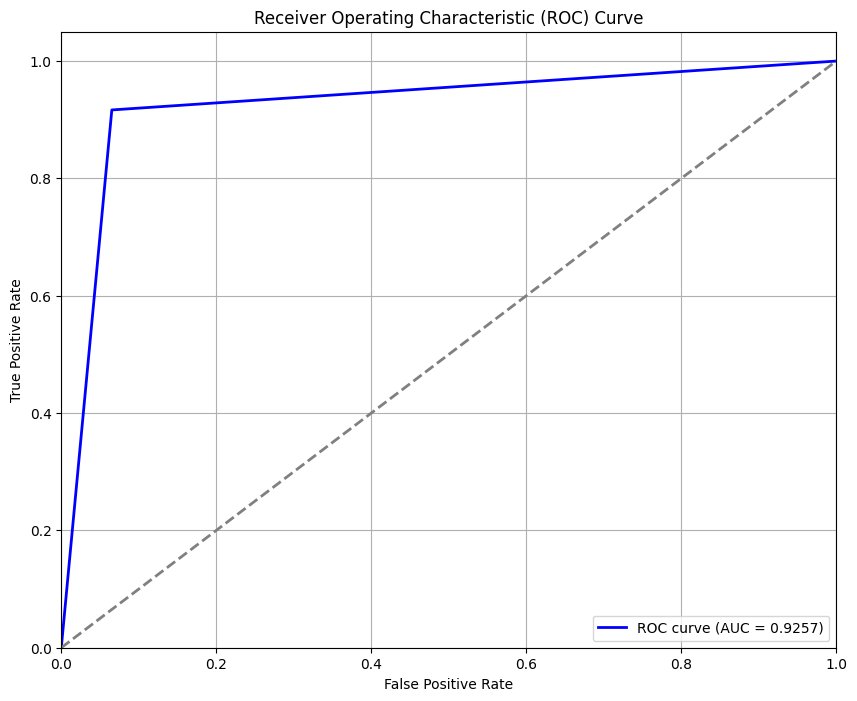

In [134]:
# Generate ROC curve


try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve
    from sklearn.metrics import accuracy_score, roc_auc_score

    final_auc = roc_auc_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {final_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('roc_curve.png')
    print("\nROC curve saved as 'roc_curve.png'")
except ImportError:
    print("Matplotlib or scikit-learn not available. Skipping ROC curve plot.")
except Exception as e:
    print(f"Error generating ROC curve: {str(e)}")

In [105]:
#get test features the same way
test_df=pd.read_parquet('TARP_Kaggle_test0.par')
X = pd.DataFrame()
#adds collumns from engineered features
#X = pd.concat([X, returns], axis=1)
tradeStats = get_trade_Stats(test_df)
tradeStats.index = test_df.index
busiest = get_busiest_times(test_df)
busiest.index = test_df.index
absolute = get_absolute_open(test_df)
absolute.index = test_df.index
aggregated_volume_features = get_aggregated_volume_features(test_df)
aggregated_volume_features.index = test_df.index
interaction_features = compute_interaction_features(test_df, ["XLF", "SPY", "QQQ", "XLE", "XLY"])
interaction_features.index = test_df.index

X = pd.concat([X, tradeStats.filter(like="volatility")], axis=1)
X = pd.concat([X, busiest], axis=1)
X = pd.concat([X, absolute], axis=1)
X = pd.concat([X, aggregated_volume_features], axis=1)
#X = pd.concat([X, interaction_features], axis=1)
test_df = X


In [145]:
#counts NAN in X_train
NAN = test_df.isna().sum()

#replace NAN with 0
test_df = test_df.fillna(0)

#checks collumns of X and test_df for inequality
X_cols = X.columns
test_df_cols = test_df.columns
for col in X_cols:
  if col not in test_df_cols:
    print(col)

volatilityXLF
XLF_Morning_volatility
XLF_Afternoon_volatility
volatilitySPY
SPY_Morning_volatility
SPY_Afternoon_volatility
volatilityQQQ
QQQ_Morning_volatility
QQQ_Afternoon_volatility
volatilityXLE
XLE_Morning_volatility
XLE_Afternoon_volatility
volatilityXLY
XLY_Morning_volatility
XLY_Afternoon_volatility
volatility
XLF_Busiest_Time
XLF_Busiest_Time_Volume_Inc
SPY_Busiest_Time
SPY_Busiest_Time_Volume_Inc
QQQ_Busiest_Time
QQQ_Busiest_Time_Volume_Inc
XLE_Busiest_Time
XLE_Busiest_Time_Volume_Inc
XLY_Busiest_Time
XLY_Busiest_Time_Volume_Inc
XLF_Abs_Open_Sum
SPY_Abs_Open_Sum
QQQ_Abs_Open_Sum
XLE_Abs_Open_Sum
XLY_Abs_Open_Sum
Open_Abs_Sum_Avg
Open_Abs_Sum_Total
XLF_Total_Volume
XLF_Avg_Volume
XLF_Median_Volume
XLF_Vol_Ratio_1450
XLF_Vol_Concentration
SPY_Total_Volume
SPY_Avg_Volume
SPY_Median_Volume
SPY_Vol_Ratio_1450
SPY_Vol_Concentration
QQQ_Total_Volume
QQQ_Avg_Volume
QQQ_Median_Volume
QQQ_Vol_Ratio_1450
QQQ_Vol_Concentration
XLE_Total_Volume
XLE_Avg_Volume
XLE_Median_Volume
XLE_Vol_Ra

In [107]:
#makes a prediction dataframe of the training data and save it to a cv file
y_pred = best_model.predict(test_df)
y_pred = pd.DataFrame(y_pred, columns=['post_TARP'])


y_pred_prob = best_model.predict_proba(test_df)[:, 1]
threshold = 0.3  # Lower the threshold to capture more positives
y_pred = (y_pred_prob >= threshold).astype(int)
y_pred = pd.DataFrame(y_pred, columns=['post_TARP'])

#count ones
y_pred['post_TARP'].value_counts()
#add collumn to y_pred to store the index
y_pred.insert(0, 'index', test_df.index)
y_pred.to_csv('FreeLunch9.csv', index = False)
y_pred

,index,post_TARP
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
82,82,0
83,83,0
84,84,1
85,85,0
